## Parse all images to text

merged: 2
filtered: 1
last_rect: 1
[[  0   0]
 [154   0]
 [154 106]
 [  0 106]]
Cropped image saved to /Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/output/cropped_images/cropped_0.png


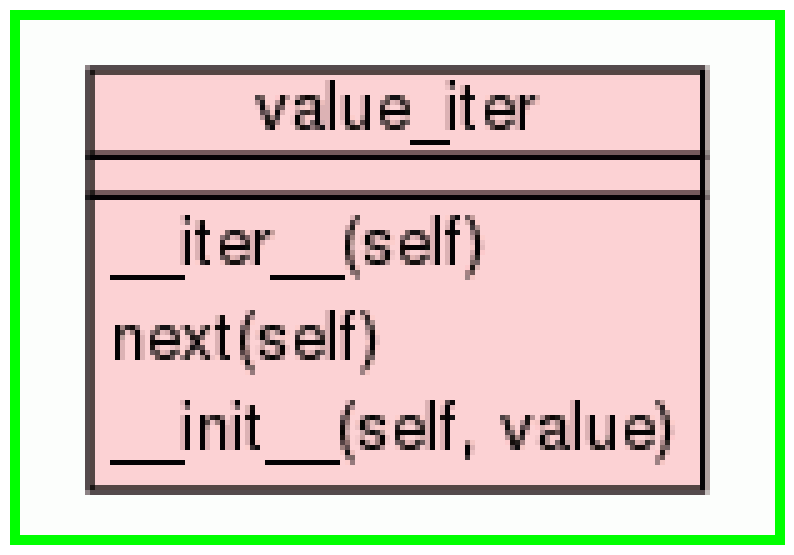

In [432]:
from pythonscript.rectangle_parser import run_parser
image_path = ("/Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/data_models/94_swift-lldb/uml_class_diagram_for_lldb_val_2.png")
output_dir = "/Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/output"  

run_parser(image_path, output_dir)


## Save the text as file

In [433]:
from pythonscript.image_to_text import run_text
from pythonscript.image_to_text import process_directory
from pythonscript.image_to_text import generate_plantuml

# Test the functions separately
input_base_dir = "/Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/output/cropped_images"
output_base_dir = "/Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/output/text"

# Test process_directory
try:
    all_classes = process_directory(input_base_dir, output_base_dir)
    print("Classes extracted:", all_classes)
except Exception as e:
    print(f"Error in process_directory: {e}")

# Test generate_plantuml if all_classes is not empty
if all_classes:
    try:
        plantuml_syntax = generate_plantuml(all_classes)
        print("Generated PlantUML syntax:\n", plantuml_syntax)
    except Exception as e:
        print(f"Error in generate_plantuml: {e}")
else:
    print("No classes to generate PlantUML.")



Text saved to /Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/output/text/cropped_0.txt
Classes extracted: ['_iter_(self\nnext(self)\n_ init__(self, value)']
Generated PlantUML syntax:
 @startuml
class _iter_(self {
  next(self)
  _ init__(self, value)
}
@enduml


## Conversion svg to png

In [434]:
from pythonscript.converting_files_svg_to_png import run_conversion
run_conversion()

18_google-api-python-client
61_unknown-horizons
47_game-of-life
.DS_Store
94_swift-lldb
29_netty-learning
46_grobid
58_pjproject
81_activejdbc
82_spring-net
34_core-plot
55_octomap
32_RakNet
50_yard
74_di
53_LibrePCB
75_usergrid
37_android_design_patterns_analysis
73_sonar-java
99_jsoup-learning
80_DebugViewPP
68_mayavi
26_cgal
51_AsciidocFX
17_android-open-project-analysis


'All SVG files have been converted to PNG.'

## Conversion gif to png

In [435]:
from pythonscript.converting_files_gif_to_png import run_gif_conversion
run_gif_conversion('data_models/18_google-api-python-client')

Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_21.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_21.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_20.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_20.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_22.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_22.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_9.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_9.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_37.gif to data_models/18_google-api-python-client/uml_class_diagram_for_googleap_37.png
Converted data_models/18_google-api-python-client/uml_class_diagram_for_googleap_18.gif to data_models/18_google-api-python-client/uml_class_diagram_for_goog